# Overview: Building Micrograd

- Source: [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

- GitHub: [Micrograd](https://github.com/karpathy/micrograd)

## What is Micrograd?

- Micrograd is an Autograd engine

- Autograd stands for automatic gradient

- Automatic gradient means it implements the backpropagation alogirithm automatically

- Backpropagation is an algorithm to compute the gradient of a loss function with respect to the weights of a neural network which allows you to iteratively tune the weights of this neural network to minimize the loss function and improve the accuracy of the neural network

## Micrograd Introduction

In [ ]:
%pip install micrograd

In [2]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


## Explanation

- Micrograd allows you to create mathematical expressions, calculate the forward pass, calculate the backpropagation for them, and view the gradient at each node in the expression graph

- Forward pass means you calculate the output for the given inputs
  - Ex. y(x) = 5x + 2 = 12 when x = 2

- Backwards pass means you calculate the gradient at each node with respect to the output
  - Ex. dy/dx = 5

## Parallels to Neural Networks

- Neural networks are similarly mathematical expressions and we want to calculate forward pass and backward pass

- They take the input data as inputs, weights and biases of the neural network as inputs, and calculates an output (or loss function)

## Note on Backpropagation

- Not specific to neural networks but is more general and is only being applied to neural networks in this case

## Note on Simplified Model

- With Micrograd, we're working at the level of individual scalar values (ex. -1.0, 5.0, 2.0) for simplicity

- With neural networks used in production, they're made of of n-dimensional tensors which are arrays of many floating point numbers

# Fundamentals

## What is a derivative?

- Take as an example the mathematical expression defined below

In [ ]:
%pip install numpy
%pip install matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
  return 3*x**2 - 4*x + 5

In [7]:
f(3.0)

20.0

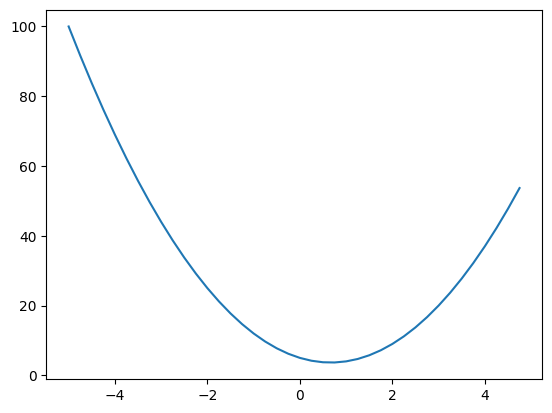

In [13]:
# We can plot this

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## What is the derivative of this function for any x?

For a very small increase in x, how does the output y respond? What is the slope (rise / run) of this change?

- We can estimate this by increasing x by a small amount h

In [19]:
x = 3.0
f(x)

20.0

In [21]:
h = 0.001
f(x+h)

20.014003000000002

In [22]:
# Numerical estimate of derivative at x = 3
(f(x+h) - f(x)) / h

14.00300000000243

In [23]:
# Numerical estimate of derivative at x = -3
x = -3
(f(x+h) - f(x)) / h

-21.996999999998934

## Now let's consider a more intricate expression

- We will consider the derivative of the output d with respect to each input variable a, b, and c

In [25]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

4.0


In [31]:
# Numerical approximation of the derivative of each input with respect to the output

h = 0.0001

# a
# d = -3a + 10
# dd/da = -3

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
print('a expected slope', -3)
print()

# b
# d = 2b + 10
# dd/db = 2
d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
print('b expected slope', 2)
print()

# c
# d = -3*2 + c
# dd/dc = 1
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)
print('c expected slope', 1)
print()

d1 3.9997001999999977
d2 3.9994002399999973
slope -2.999600000004321
a expected slope -3

d1 3.9994002399999973
d2 3.9996002999999973
slope 2.000600000000574
b expected slope 2

d1 3.9996002999999973
d2 3.999700299999997
slope 0.9999999999976694
c expected slope 1



# Let's start to build out Micrograd

- First consider a basic implementation of a Value object

- All it does is wrap a value and print in a readable form

In [32]:
class Value:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

In [35]:
a = Value(2.0)
b = Value(3.0)

In [37]:
a, b

(Value(data=2.0), Value(data=3.0))

# Add an Add function to it

- This will add two Value objects

- __add__ basically overrides the '+' operator so that __add__ is called with the expression a + b

In [42]:
class Value:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

a = Value(2.0)
b = Value(3.0)
a + b

Value(data=5.0)

# Add a Multiply function

- Same as Add, it will override the '*' operator so that __mul__ is called

In [43]:
class Value:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data)
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

a = Value(2.0)
b = Value(3.0)
a * b

Value(data=6.0)

# Maintain a history of how the value came to be

- We will maintain which previous Values were used to get the current Value object's value and what operator sign was used

In [76]:
class Value:

  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

In [78]:
d._op
d._prev

{Value(data=-6.0), Value(data=10.0)}

# Visualizing the expression

In [ ]:
%pip install graphviz

In [81]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ data %.4f }" % (n.data, ), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

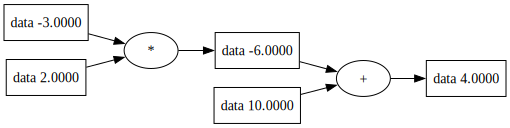

In [82]:
draw_dot(d)

# Labeling the graph nodes

In [83]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [86]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

# Update graph function to include the Label

In [88]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

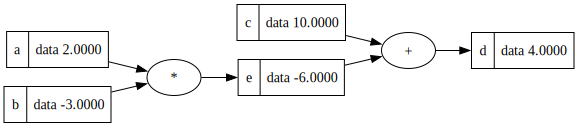

In [89]:
draw_dot(d)

# Add more to our example expression

In [95]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

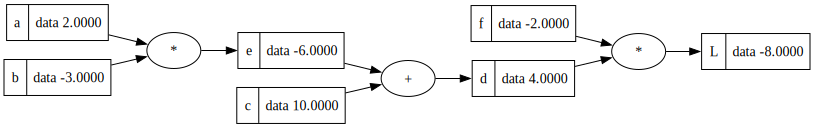

In [96]:
draw_dot(L)

# Recap of what we've done so far

- We're able to build out mathematical expressions using scalar values and + and * operations

- We can do a forward pass with the inputs into the mathematical expression to get an output value

# What's next?

- Now we want to run backpropagation

- We'll start at the end, go backwards through the mathematical expression, and calculate the gradient at each intermediate node value

- This means we'll be calculating the derivative of the output L with respect to each input a, b, c, and f

# How does this relate to neural networks?

- In a NN, we want to calculate the derivative of some loss function (L) with respect to the NN weights (the inputs a, b, c, f in the example)

- How are the weights impacting the output? This enables us to tune the weights to minimize the loss function aka. improve the accuracty of the NN

# Update Value class to include a gradient value

In [100]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

# Update the graphing function to include the gradient

In [101]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot

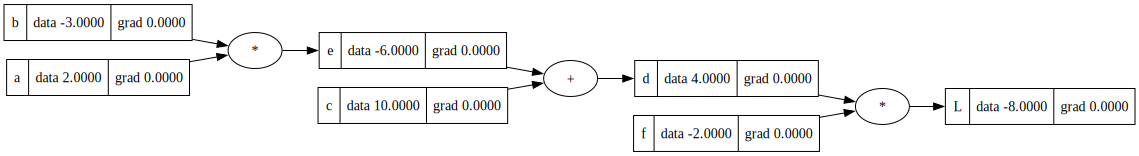

In [103]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L
draw_dot(L)

# Now let's do manual back propagation

- First start with dL / dL

- If we increase L by some small amount h, then the rise / run would be 1 because the rise would increase proportionally to the run

- We can also use numerical approximation to confirm this as well

In [107]:
# We'll use a function for this to prevent impacting the global scope

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data + h

  print((L2-L1)/h)

numerical_approximation_of_derivative()

0.9999999999621422


In [108]:
# Manually set L node grad value to 1.0
L.grad = 1.0

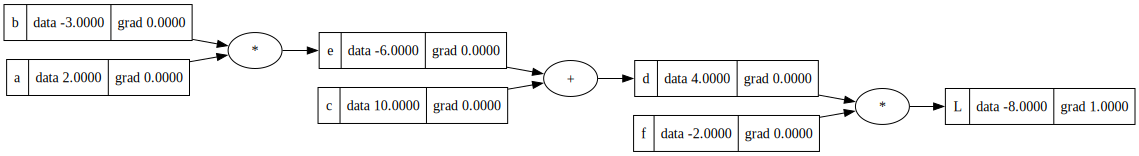

In [109]:
draw_dot(L)

In [111]:
# Now calculate derivative of d (aka dL/dd)

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

numerical_approximation_of_derivative()

-1.9999999999242843


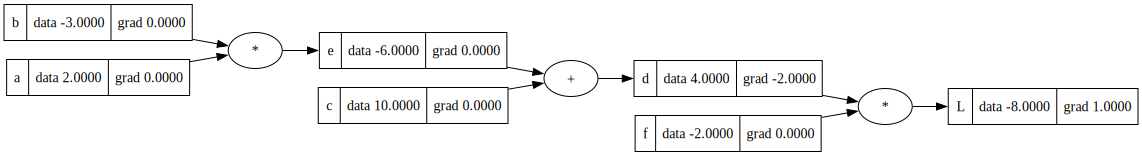

In [113]:
d.grad = -2.0
draw_dot(L)

- From the numerical approximation above, we saw dL/dd = -2 = f

- Why is this?

- We can prove it based on the definition of the derivative

- Definition of derivative = (f(x+h) - f (x)) / h

- ((d+h)*f - d*f)/h = (d*f + h*f - d*f) / h = h*f / h = f

- The same logic applies to dL/df = d

- We can similarly prove this with numerical approxmiation to verify our proof

In [116]:
# Now calculate derivative of f (aka dL/df)

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

numerical_approximation_of_derivative()

4.000000000026205


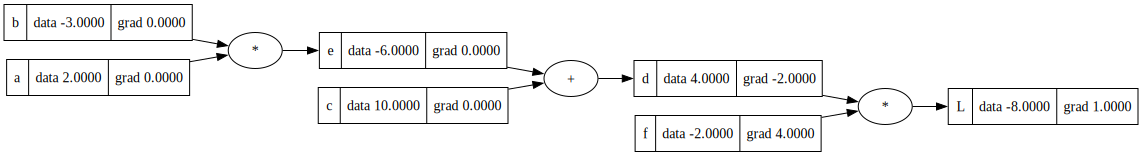

In [114]:
f.grad = 4.0
draw_dot(L)

- Now we will continue with manual backpropagation to the e and c nodes

- Since we've already calculated dL/dd , we know how L is impacted by changes to d. How can we extend this to understand how L is impacted by changes to e and c through d?

- First let's calculate dd/de and dd/dc and see how to use this to calculate dL/dd and dL/dc 

- We can use a proof first, then do a numerical approximation to confirm



Calculating dd/dc first

d = e + c

(f(x+h) - f(x)) / h

((c+h + e) - (c + e)) / h = (c + h + e - c - e) / h = h / h = 1.0

Same for dd/de

((c + e+h) - (c + e)) / h = (c + e + h - c - e) / h = h / h = 1.0

## Now how do we tie these local derivatives dd/dc and dd/de to get dL/dc and dL/de?

- Use the Chain Rule from Calculus

  - dz/dx = dz/dy * dy/dx

  - An intuitive explanation of the Chain rule is, "If a car travels twice as fast as a bicycle, and a bicycle travels 4 times as fast as a person, then the car travels 2*4 = 8 times as fast as a walking person"



- We know dL/dd = -2.0, dd/dc = 1.0, and dd/de = 1.0

  - To get dL / dc then, we do dL/dc = dL/dd * dd/dc = -2.0 * 1.0 = -2.0

  - Similarly, dL/de = dL/dd * dd/de = -2.0 * 1.0 = -2.0

## Important insight: Addition just routes the derivative

- Since local derivatives of addition operations are 1.0 as we saw above, from the chain rule, we can see that the derivative will just be routed along unchanged when a + operation is encountered

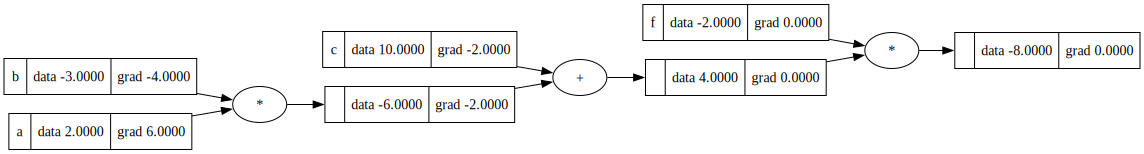

In [154]:
# Now update the gradients and redraw the graph
# Notice that the grad at node d just distributes the same grad to all of its children nodes
e.grad = -2.0
c.grad = -2.0
draw_dot(L)

In [120]:
# Similarly, these gradients dL/de and dL/dc can be confirmed with numerical approximation like before
# First do dL/de

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  e.data += h
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

numerical_approximation_of_derivative()


-1.9999999999242843


In [121]:
# And then dL/dc

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0 + h, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

numerical_approximation_of_derivative()

-1.9999999999242843


## Now apply the Chain rule again to calculate the gradient for remaining nodes. dL/da and dL/db

- We know dL/de = -2.0

- From Chain rule, dL/da = dL/de * de/da and dL/db = dL/de * de/db

- How do we get de/da?

  - Our local expression is e = a * b

  - From before we saw for multiply operations that de/da = b and de/db = a

- Therefore, dL/da = dL/de * de/da = -2.0 * b = -2.0 * -3.0 = 6.0

- Simlilarly, dL/db = dL/de * de/db = -2.0 * a = -2.0 * 2.0 = -4.0


### And again we can verify this with numerical approximation

In [135]:
# And then dL/da

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  a.data += h
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

numerical_approximation_of_derivative()

6.000000000128124


In [133]:
# And then dL/db

def numerical_approximation_of_derivative():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'

  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

numerical_approximation_of_derivative()

-4.000000000026205


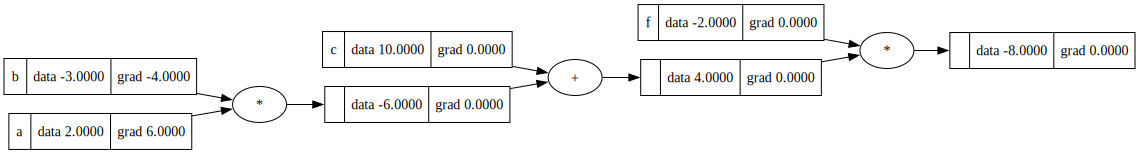

In [147]:
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

# Recap

- We've manually backprogated through the mathematical expression

- Backpropagation is applying the Chain rule to calculate the derivative and propagating it through the expression

# How can we nudge the inputs to increase the output of L?

- If we take L to be the output of the neural network, or the Loss function, then the goal is to adjust the weights and biases of the NN to minimize this loss function

- In this step we will manually adjust the inputs to our example mathematical expression to increase the value of L from what it is currently (Currently -8.0 so we want to increase it towards 0)

- Since we know the gradients at each node, we know what the impact of increasing/decreasing these values will have on the output L
    
- A positive gradient means increasing that node value would increase L, and a negative gradient means L would decrease if the input were increased

In [158]:
# Reset the expression values because they got messed up somewhere
a = Value(2.0, label='a')
a.grad = 6.0
b = Value(-3.0, label='b')
b.grad = -4.0
c = Value(10.0, label='c')
c.grad = -2.0
e = a*b; e.label = 'e'
e.grad = -2.0
d = e + c; d.label = 'd'
d.grad = -2.0
f = Value(-2.0, label='f')
f.grad = 4.0
L = d * f
L.label = 'L'

# Only adjust the leaf nodes since these are the inputs we have control over

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


# Backpropagation through a neuron

- Now we will do manual backpropagation through one neuron of a neural net

- A neural network in its simplest case is a multi-layer perceptron. There is an input layer, output layer, and some number of hidden layers in-between.

  - The layers are made up of neurons. Each neuron is fully connected to the layers of its previous layer and its next layer

  - The inputs to the neuron are multiplied by the weights of that connection plus some bias intrinsic to the neuron that indicates its propensity for "firing" or being activated

- The input to the neuron then is the sum of all the inputs * synapse weights + the neuron bias. This is fed to an activation function which squishes this result to be between 0 and 1

- A common activation function is tanh which has the property of being 0 at input 0 and curve towards 1 as the max value as the input increases. See the plot below for the tanh function

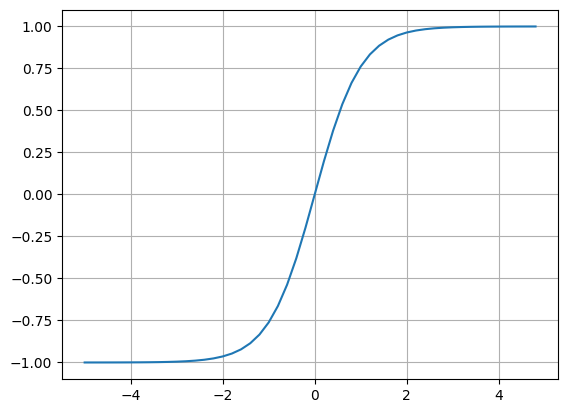

In [159]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

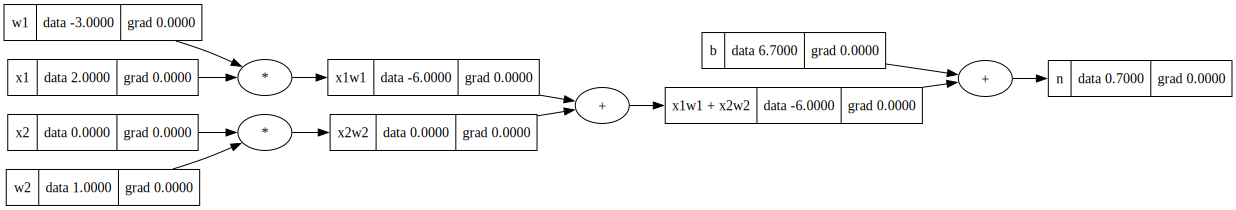

In [160]:
# Here is a graph of a single neuron with two inputs x1, x2

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)


# Implementing the tanh function

- We also want to implement the tanh function, but cannot currently because Value only supports Add and Multiply

- The tanh function is (e^2x - 1) / (e^2x + 1) so we need to implement exponentiation and divide in our Value class

- We could do this by implementing and exponentiate and divide function in the Value class, but we actually can make each Value node as atomic or complex as we want. So far we have kept each value very atomic such as '+' or '*'. 

  - But we could equally so make a single Value node operation be tanh itself instead of creating each component of tanh as its own node. As long as we can differentiate through the node, then it is still usable with backpropagation


# Updating Value with tanh operation

In [164]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

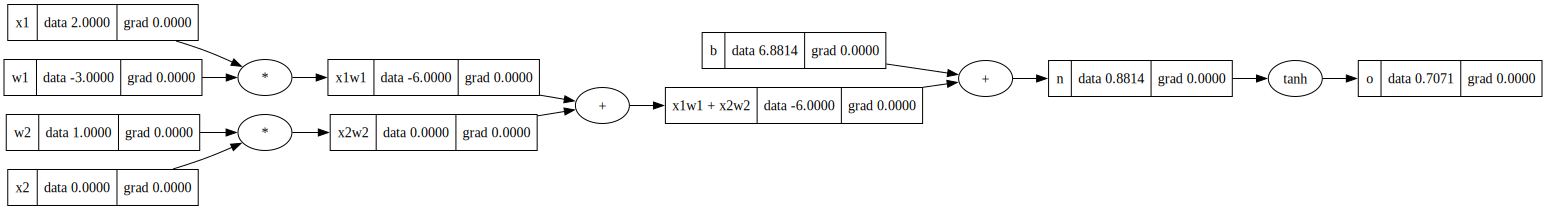

In [167]:
# Add this tanh function to our graph

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
draw_dot(o)

# Manual backpropagation

- Note that the bias was adjusted to a "weird" number to make the numbers come out better

In [168]:
# This is a given. Increasing o results in a proportional rise / run
o.grad = 1.0

First calculate do/dn

o = tanh(n)

Just look this up

do/dn = 1 - tanh(n)^2 = 1 - o^2 = 1 - (0.7071)^2

In [176]:
1 - o.data**2 # 0.5
n.grad = 0.5
n.grad

0.5

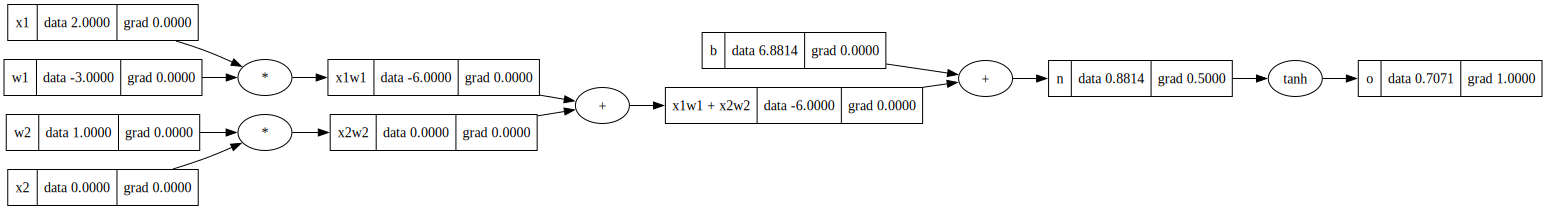

In [178]:
draw_dot(o)

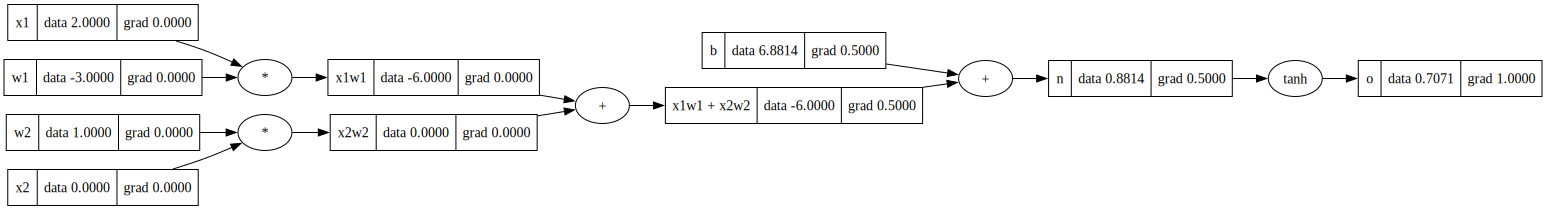

In [180]:
# The next operation is a '+'
# Remember from above that the gradient just distributes to the child nodes in the case of a '+' operation

b.grad = 0.5
x1w1x2w2.grad = 0.5

draw_dot(o)

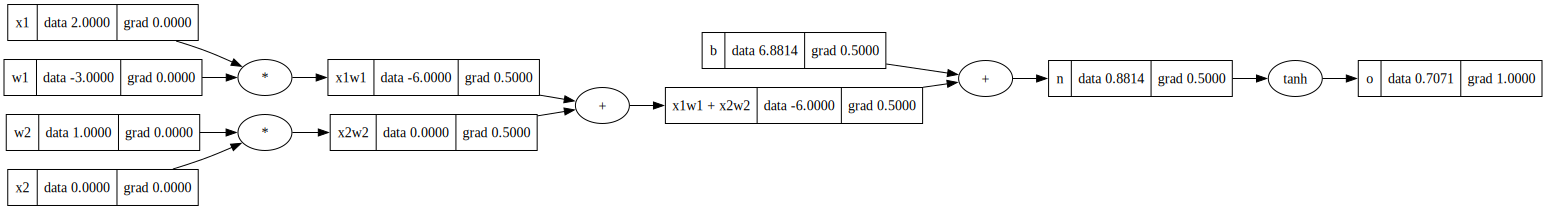

In [181]:
# Same for the next operation
# It is a '+' so just distribute it

x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

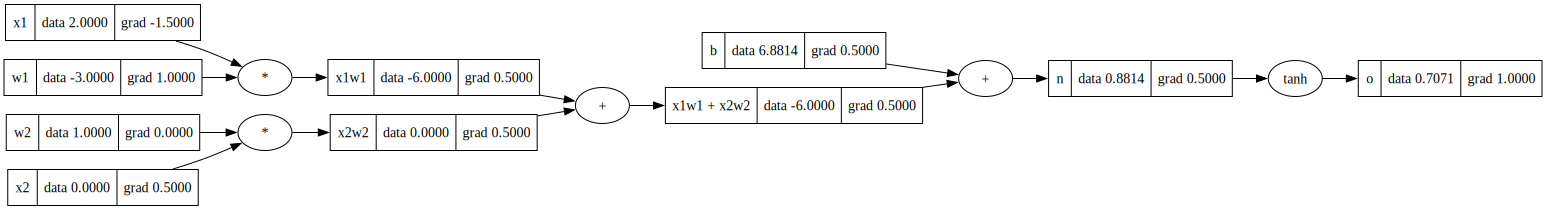

In [184]:
# The next operations are '*'
# Remember from above that this is just *'s the opposite nodes data value

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

draw_dot(o)

# Implementing Backpropagation automatically

- Manually calculating the backpropagation is obviously not scalable, so we want to find a way to cacluate this automatically for a given expression

- We can update the Value class to include a backwards function which will be used for this

  - This function will run the Chain rule to take in the input gradients and cacluate the outputs gradient

  - By default _backwards is None which means it does nothing. This would be the case for a leaf node for instance

In [185]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

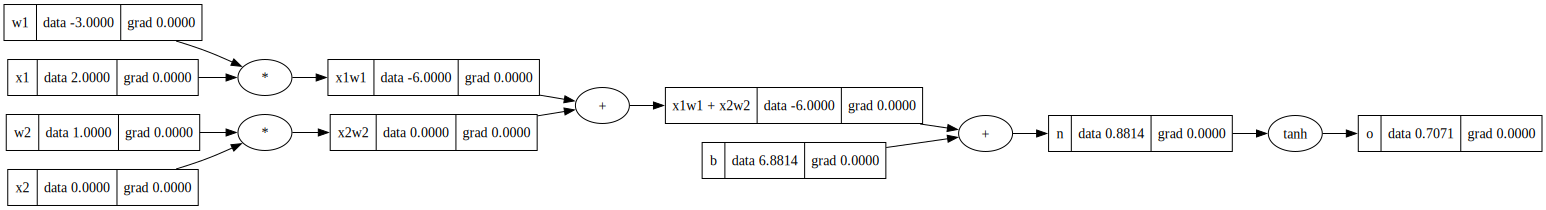

In [186]:
# Re-initialize the expression

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
draw_dot(o)

- As a base case, we must set o.grad = 1.0 because otherwise the first call to o._backward() will just be 0

- This is because this first call to o._backward() = self.grad = (1 - t**2) * out.grad and if out.grad = 0.0 , then this will always be 0

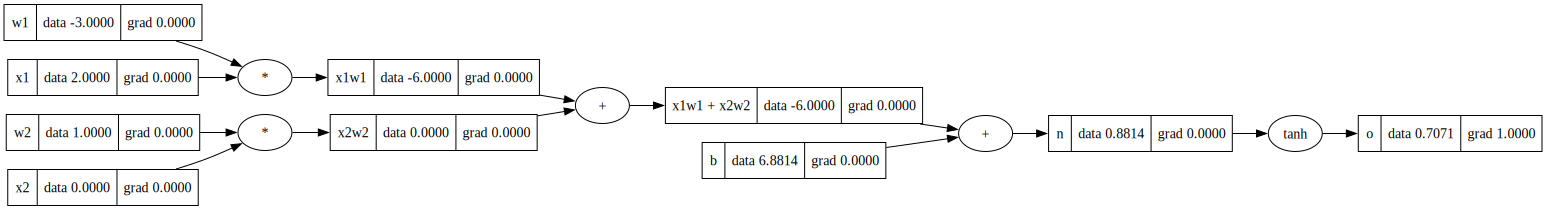

In [187]:
o.grad = 1.0
draw_dot(o)

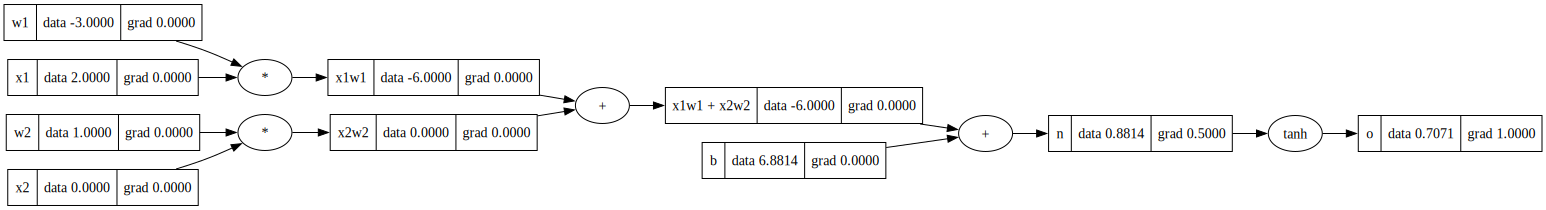

In [189]:
# Now calculate the first gradient

o._backward()
draw_dot(o)

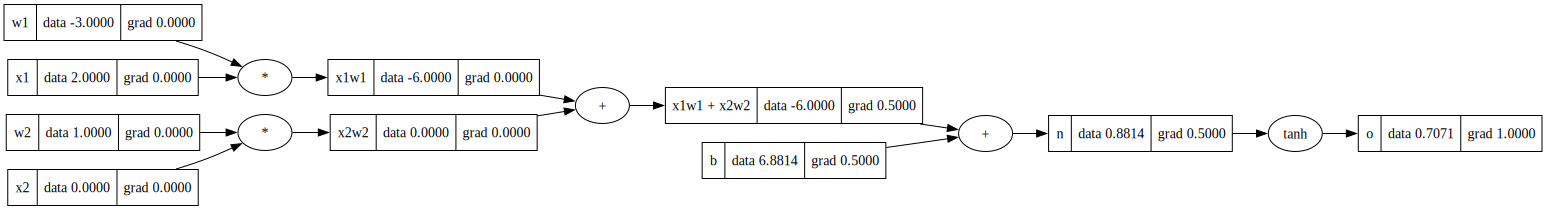

In [190]:
n._backward()
draw_dot(o)

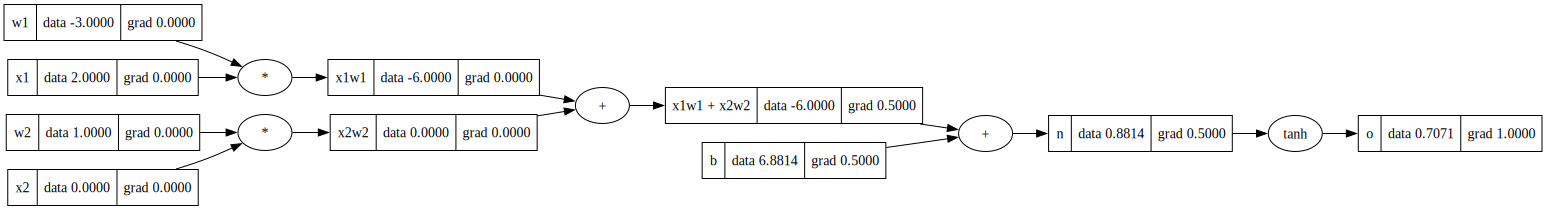

In [191]:
# b is a leaf node whose _backward function is initialized to None
# When we call b._backward() on it, nothing will happen

b._backward()
draw_dot(o)

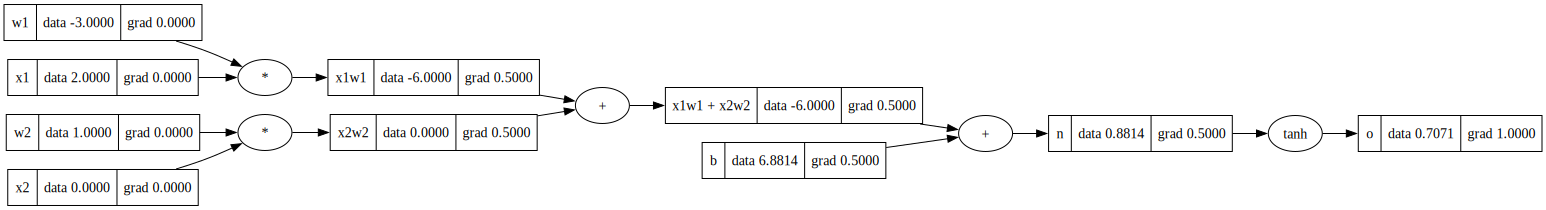

In [192]:
x1w1x2w2._backward()
draw_dot(o)

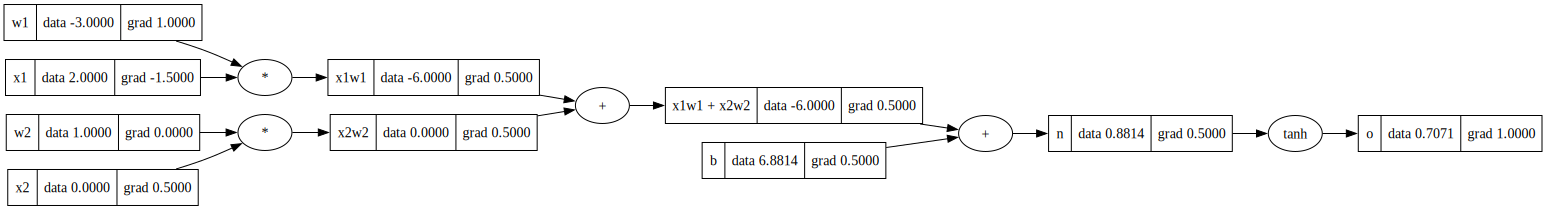

In [193]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

# How to call _backward() in the right order automatically?

- We do not want to have to call _backward() on each node manually. How can we do this automatically and in the correct order?

- We can use topological sort to order the nodes from last output node to beginning input nodes. Then we'll traverse through this sort from output node to input nodes calling _backward() on each node as we go

In [194]:
# Topological sort algorithm

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

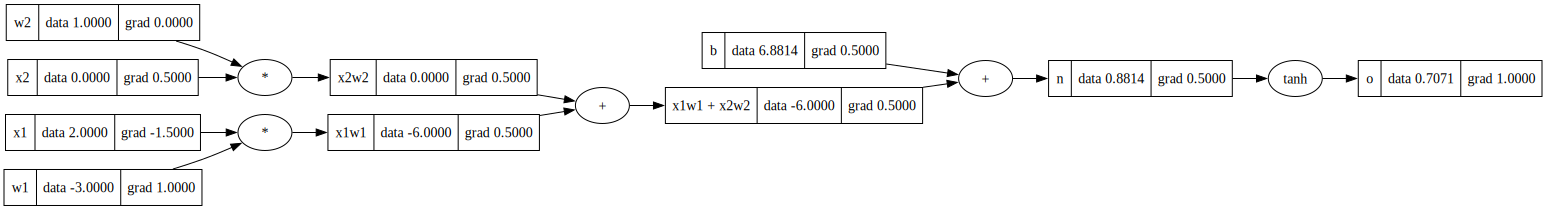

In [197]:
# Putting these together, we can reset our expression
# First initialize o.grad = 1.0 for the reason mentioned above
# Call build_topo(o) to create the topological sorted graph
# Call _backward() on each node from output node o to the input nodes

# Re-initialize the expression

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

# Initialize o.grad = 1.0
o.grad = 1.0

# Topological sort the nodes
build_topo(o)

# Call _backward in reverse order of the topological sort
# The topo sort gives the nodes from input to output. We want to caculate _backward from output to input
for n in reversed(topo):
  n._backward()

draw_dot(o)

- Now we can add a new backward() function to the Value class that does all of the steps we just did above

In [221]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()


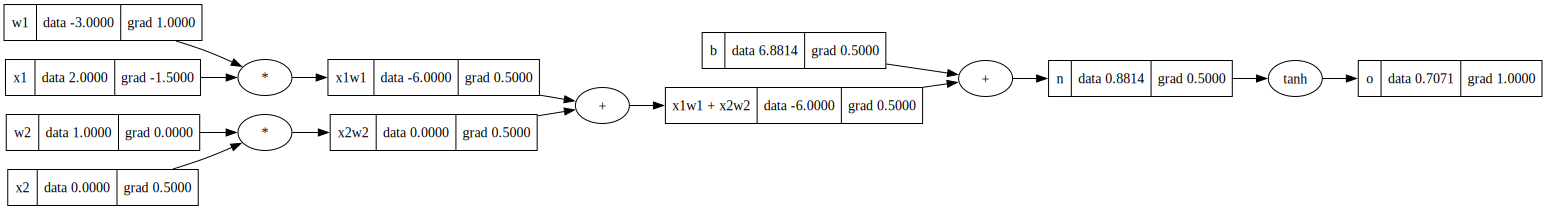

In [222]:
# Now re-initialize the expression and call the new backward() function

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

# Call backward() function
o.backward()

draw_dot(o)

# There is a bug in our code!

- With the expression used so far, the bug has not surfaced because of how the expression is set up

- If we create a new expression where nodes are used more than once, we will see the bug

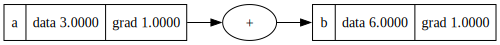

In [223]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

- The expression b = a + a = 2a , which means that db/da = 2

- But our automatic calculation of the gradient shows it is 1.0

- In our Value class, self.grad = 1.0 * out.grad = 1.0 * 1.0 = 1.0 when calculating the first a node
-  When calculating the second a node, which is actually the same a node, this self.grad gets overridden back to 1.0
-  We need to make these gradients add to one another to fix this case  

```
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out
```

- Value class _backward functions will become like this

```
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
```

- We can see this same bug for another more complicated expression

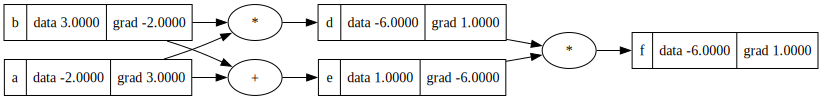

In [225]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

- The multi-variable Chain rule states that derivatives should be accumulated
- https://www.youtube.com/watch?v=9yCtWfI_Vjg

- Consider a function with two inputs and one output. W has two inputs, x and y, and x and y are themselves functions depending only on a single variable t

w = f( x(t) , y(t) )

- Chain rule in this case states that:

dw/dt = dw/dx * dx/dt + dw/dy * dy/dt

- Now we have our updated Value class where the gradients are adding in the Add and Multiply cases

In [227]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

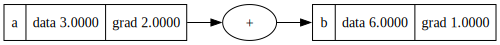

In [228]:
# Now we can verify the broken examples above now work

a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

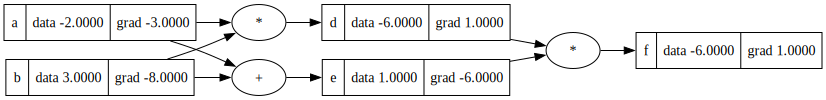

In [229]:
# And the other example too

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

# Implementing tanh as atomic pieces

- Previously we mentioned that the nodes of the expression can be created as arbitrarily complex or simple (e.g. atomic) as we want. As long as we can differentiate through the node, then it does not impact the result

- We did this with the tanh function, which we implemented as its own node instead of its atomic pieces (i.e. tanh = (e^2x - 1) / (e^2x + 1) )

- As a prerequisite, we are going to update the Value calss to be able to handle the case where we try to add a number by itself in the expression without it already being defined as a Value object

- For example, this will not work currently because 1 is not a Value object and the add() function only adds two Value functions

a = Value(2.0)
b = a + 1

In [231]:
# We add this line to the add() function to wrap any integer values to be a Value object if needed
# other = other if isinstance(other, Value) else Value(other)

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

- Similarly, we want to update Value to handle the case if we multiply an integer by some Value object

- Currently this will fail in this case:

a = Value(2.0)
2 * a

- But it will work in this case

a * 2

- This is because within Python, when these expressions are evaluated, it does this

2.__mul__(a)

and

a.__mul__(2)

There is no __mul__ function defined for the integer 2

- To get around this, we can define __rmul__ which basically overrides the * operator so that Python checks this function first when evaulating something like 2 * a or 2.__mul__(a). It will do 2.__rmul__(a)

- The way __rmul__ is implemented below is that it will just swap the order if it encounters something like 2 * a so that it becomes a * 2 or a.__mul__(2_)

In [239]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

In [243]:
# Test and verify this
a = Value(2.0)
6 * a
a * 9

Value(data=18.0)

## Now we need to implement the exp function

Since tanh uses exponent functions within it, we must add this to the Value class


In [244]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

In [245]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

## Now we need to implement a divide function

- We can actually represent division as raising some number to an exponent

a = Value(2.0)
b = Value(4.0)

a / b = a * (1/b) = a * (b ** -1)

Or more generally we want to implement x ** k for any integer or float value of k and when k = -1 will be a special case that we're doing division

In [246]:
# First override the / operator by defining __truediv__ so that it calls our __pow__ function instead
# Then implement the __pow__ function to handle the exponentiation operator

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # This comes from power rule in calculus If e(x) = x^n then de/dx = n*x^(n-1)
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other
  
  def __truediv__(self, other):
    return self * other**-1
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

In [247]:
# Now test it

a = Value(2.0)
b = Value(4.0)

a / b

Value(data=0.5)

## Now we must add a subtract operation

In [333]:
# We can implement subtraction as an addition of a negation
# i.e. 2 - 3 = 2 + (-3)
# This means we implement __sub__ and __neg__

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __radd__(self, other): # other + self
    return self + other
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  
  def __rsub__(self, other): # other - self
    return other + (-self)
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # This comes from power rule in calculus If e(x) = x^n then de/dx = n*x^(n-1)
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other
  
  def __truediv__(self, other):
    return self * other**-1
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()

In [252]:
# Verify it works

a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

- Now let's compare the expression using the tanh node and using our new atomic operation nodes that comprise tanh to verify that they are equivalent

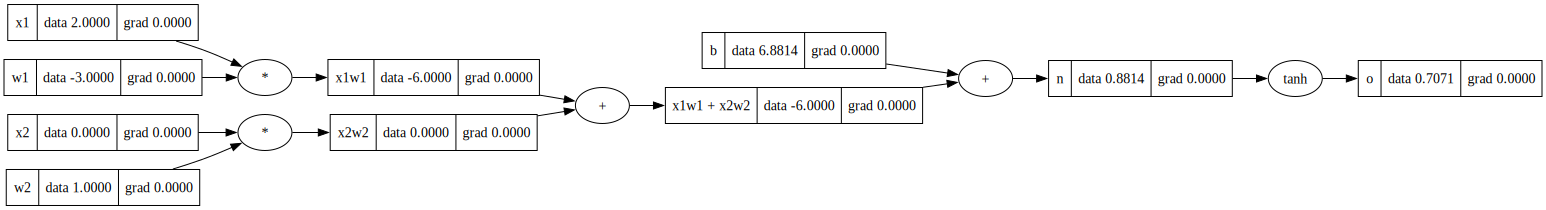

In [253]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
draw_dot(o)

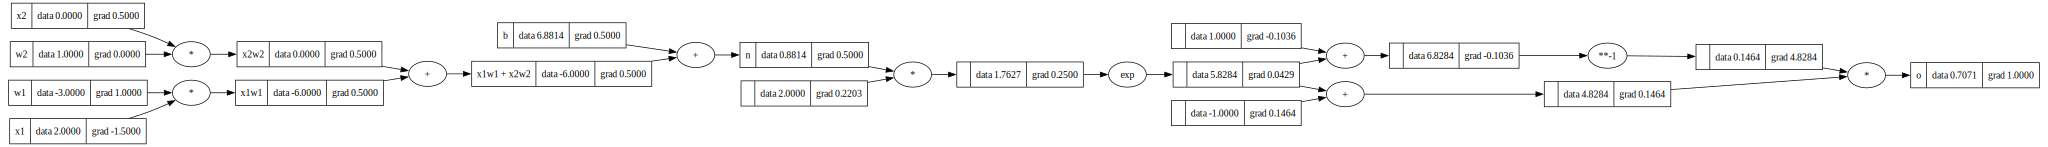

In [306]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

## tanh made up of atomic pieces
e = (2*n).exp()
o = (e - 1) / (e + 1)
##

o.label = 'o'
o.backward()
draw_dot(o)

# Do it in PyTorch

- We will now implement this in PyTorch to show they are equivalent

- Micrograd is loosely based on the PyTorch APIs, so most of this should look essentially the same

In [ ]:
%pip install torch

## Note on similarities and differences

- Tensor is similar to our Value object
- Tensors are made up of n-dimensional scalar values, whereas Value just contained a single scalar value
- We cast the Tensor types to double() because by default Python uses double for floats and we want to match what we used previously
- By default, PyTorch assumes leaf-nodes don't require gradients, so we set this explicitly with x1.requires_grad = True

In [258]:
import torch

x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


- As you can see, we get the same result
- Using PyTorch, we can do the same thing we did with the mathematical expressions
- PyTorch is very efficient and allows us to do the same thing we did with Micrograd but with n-dimensional Tensors and in parallel

# Building a Neural Network

- So far we have used Micrograd to build out arbitrary mathematical expressions

- Neural networks are a certain class of mathematical expressions

- We will begin updating Micrograd to build out specifically neural network mathematical expressions

- We will use this to create a 2-layer multi-layer perceptron

## Building out the Neuron class

- We did implement a neuron with Micrograd already above, but now we will create a Neuron class to mirror the API of PyTorch

In [268]:
import random

In [279]:
class Neuron:

  # nin = number of inputs to neuron
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out


x = [2.0, 3.0]
n = Neuron(2)

n(x)

Value(data=0.7378564872103871)

## Now create a Layer class

- This will maintain a layer of many neurons

In [281]:
class Layer:

  # nin = number of inputs
  # nout = number of outputs
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs
  
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.37487385489616243),
 Value(data=0.8912920362202198),
 Value(data=0.9132068888215571)]

## Now we will define a multi-layer perceptron (MLP)

- In a MLP, you have many layers and they feed into each other sequentially

In [283]:
class MLP:

  # nouts = a list of sizes of all layers we want in MLP
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
# We'll create a MLP with 3 inputs, 1 hidden layer of 4 neurons, another hidden layer of 4 neurons, and an output layer of 1 neuron
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data=0.8125521186238317)]

- Here is a good explanation of the code together with the Neuron, Layer, and MLP classes

Certainly! This code defines an `__init__` method for a neural network class. Let's break it down step by step:

1. `def __init__(self, nin, nouts):`
   - This is the constructor method for the class.
   - It takes two parameters:
     - `nin`: An integer representing the number of input neurons.
     - `nouts`: A list of integers representing the number of neurons in each subsequent layer.

2. `sz = [nin] + nouts`
   - This line creates a new list `sz` (likely short for "sizes").
   - It combines the input size `nin` with the list of output sizes `nouts`.
   - For example, if `nin = 3` and `nouts = [4, 5, 2]`, then `sz` would be `[3, 4, 5, 2]`.

3. `self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]`
   - This line creates a list of `Layer` objects and assigns it to `self.layers`.
   - It uses a list comprehension to create these layers.
   - For each layer:
     - `sz[i]` is the number of neurons in the current layer.
     - `sz[i+1]` is the number of neurons in the next layer.
   - The `range(len(nouts))` determines how many layers to create.

Let's look at an example:
If `nin = 3` and `nouts = [4, 5, 2]`, then:
- `sz` would be `[3, 4, 5, 2]`
- The layers created would be:
  1. `Layer(3, 4)` (input layer to first hidden layer)
  2. `Layer(4, 5)` (first hidden layer to second hidden layer)
  3. `Layer(5, 2)` (second hidden layer to output layer)

This code efficiently sets up the structure of a neural network with a flexible number of layers and neurons per layer. The `Layer` class (not shown in this snippet) likely defines the weights and operations for each layer of the network.

- Since Layer is always returning a list output, we can modify it to return a single Value if the output is 1 neuron

In [284]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

In [313]:
x = [42.0, 33.0, -11.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7176869841169023)

- Now let's draw the diagram of the neural network

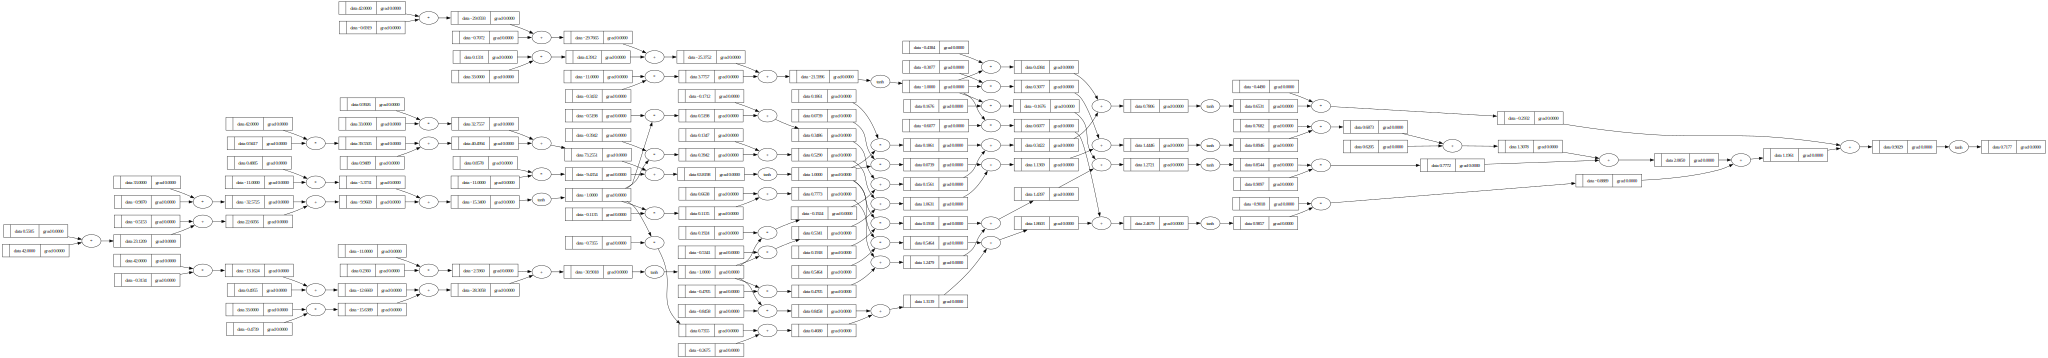

In [314]:
draw_dot(n(x))

In [291]:
n(x).backward()

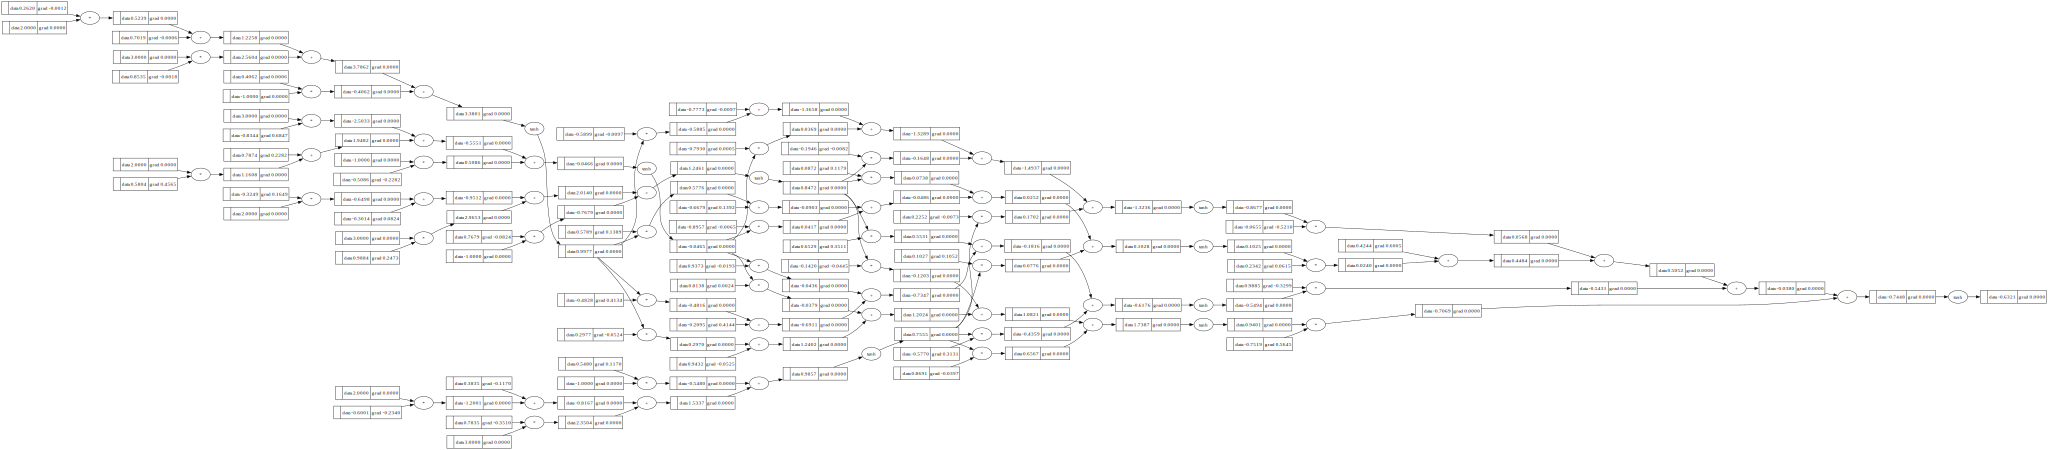

In [292]:
draw_dot(n(x))

## Now let's create a simple training example

- We'll use these training examples to tune the weights of the neural network to result in the output being closer to the expected output

In [316]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired outputs

# Get predictions of neural net
ypred = [n(x) for x in xs]
ypred

[Value(data=0.719500760528506),
 Value(data=0.788040189540587),
 Value(data=0.5460588408176331),
 Value(data=0.6695200823656136)]

- Create a loss function. This will measure how accurate the neural net's predictions were to the desired target output

- We'll use mean-squared error as our loss function

In [337]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.775282457986418)

- Now we can call the backward() pass on the MLP which will calculate the gradient at each Neuron

In [343]:
loss.backward()
n.layers[0].neurons[0].w[0].grad

0.1265843507641988

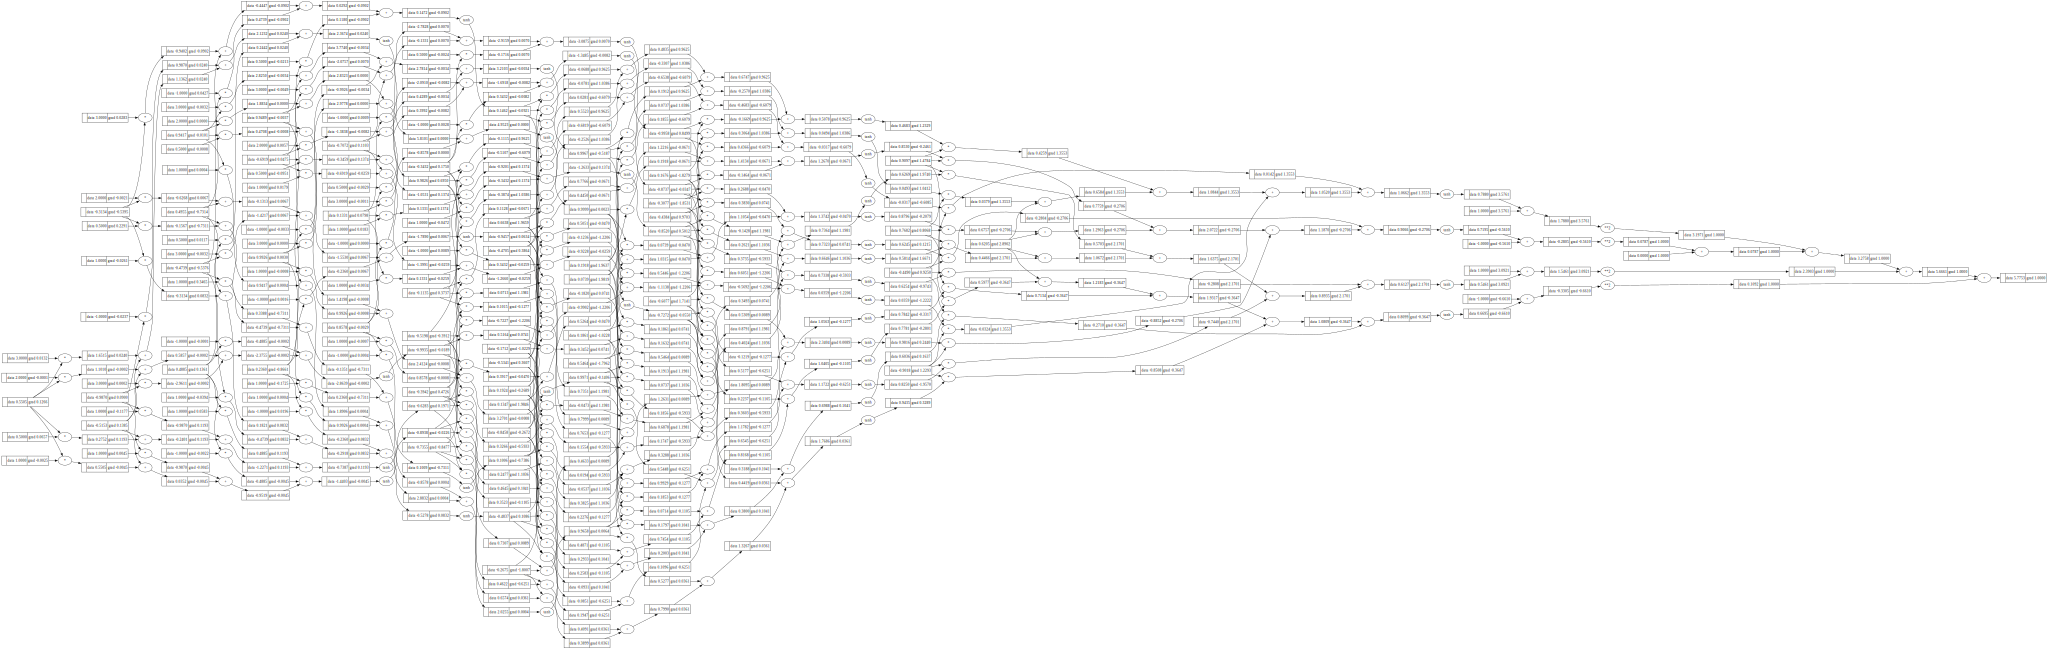

In [344]:
draw_dot(loss)

- Now we will modify our classes to make the parameters more easily accessible

 # Combine Neuron, Layer, MLP, 